# FIT5149 Applied Data Analysis - S2 2016

## Assessment 2: Predict Wine Taste Preferences with Logistic Regression 

Filename: Wine_logistic_regression.ipynb

Author: Lynn Miller

Date: 15-Sep-2016

Version: 1.0

Language: R 3.3.0 (R Core Team, 2016) and Jupyter notebook

Input files:
- Wine_training.csv - contains the data used to build the logistic regression models
- Wine_testing.csv - contains the data used to evaluate the models

Libraries used:
- boot - for bootstrap tests (Canty & Ripley, 2016)
- ggplot2 - for visualisations (Wickam, 2009)
- glmnet - for logistic regression with ridge/lasso regularisation (Friedman, Hastie, & Tibshirani, 2010). Also requires:
 - Matrix (Bates & Maechler, 2016)
 - foreach (Revolution Analytics & Weston, 2015)
- gridExtra (Auguie, 2016)
- pROC - for AUC calculations (Robin et al., 2011)

### Introduction

This notebook contains the results of the data analysis performed on the wine quality dataset from the UCI machine learning repository. The aim of the data analysis is to use variable selection and regularisation techniques to build logistic regression models to predict the quality of a wine.

The first parts of the notebook contain the steps used to build models for each of the three methods. Cross-validation is used to analyse the models built and the cross-validation results are analysed to choose the best models for each method.

After building and selecting the best models, the models are evaluated using a set of testing data to determine the best overall model. Bootstrapping the test data results is used to estimate the confidence intervals for each evaluation method. The confidence intervals provide an estimation of the variability of the performance measures and so indicate whether or not the differences between the model results are significant.

Two datasets were provided for the assignment - Wine_training.csv and Wine_testing.csv. The models were built using the Wine.training.csv dataset and evaluated using the Wine_testing.csv data.

#### Model Evaluation Statistics

The following statistics are calculated to compare the performance of the models:

- accuracy - the number of correct classifications divided by the total sample size.  
  or
- error - the number of incorrect classifications divided by the total sample size (note: $error = 1-accuracy$)
- AUC - the "Area Under the Curve"; the expectation that a uniformly drawn random "good" is ranked before a uniformly drawn random "bad" (Dernoncourt, 2015).
- deviance - the mean capped binomial deviance as used by glmnet, where the capped binomial deviance is calculated as: $−2*[Y\log(E)+(1−Y)\log(1−E)]$, where $E$ is the capped probability of each prediction (capping prevents excessively large negative log values) (Cross Validated (Pat), 2015).

In the model building steps, the final model selection for each method is made using the deviance measure. This measure has been chosen for several reasons:
- The deviance is the default measure returned by cv.glmnet for evaluating ridge and lasso regularised models. Using deviance to evaluate the stepwise selection models provides the same metric and so allows comparison between the models built using each process.
- The deviance takes the probabilities of the predictions into account, so a correct prediction of "good" with a 0.9 probability has a lower deviance than a correct prediction of "good" with a 0.6 probability. According to the Wikipedia entry for Deviance (Wikipedia, 2016), the deviance is a generalisation of using the sum of squares of the residuals.
- Accuracy and error do not take the probability of the predictions into account - so rate a correct prediction with a 0.6 probability equal with a correct prediction with a 0.9 probability. The accuracy (and error) of a model can be changed by changing the threshold at which the classification changes from "good" and "bad".
- Although AUC takes the rankings of the predictions into account, it does not use the probabilities.

When testing the selected models, the accuracy, AUC and deviance measures have all been analysed to provide a full picture of the model performance.

### Initialisation

In [1]:
# Load the required libraries
library(boot)
library(glmnet)
library(pROC)
library(ggplot2)
library(gridExtra)

# Set options
options(scipen=3, digits=4)

# Set the random seed so results are repeatable
set.seed(59731)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following object is masked from 'package:glmnet':

    auc

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
: package 'gridExtra' was built under R version 3.3.1

In [2]:
# Load the training data
wine.train <- read.csv("Wine_training.csv")

#### Function to Test a GLM or GLMNET Model

Name: testModel

Input parameters:
- model - the model to use for predictions
- X - the predictor variables 
- y - the true labels
- s - the regularisation factor lambda; use NA if model does not use regularisation (default is NA)
- CI - boolean indicating whether or not to return 95% confidence intervals for the tests (default is FALSE)

Return Value:

A list containing:
- accuracy - the accuracy of the predictions (assumes threshold of 0.5)
- deviance - the mean deviance from a model that would exactly fit the data
- AUC - the AUC for the predictions.

Each of the above is a scalar value if confidence intervals have not been requested. If confidence intervals have been requested then each element is a list of the mean, CI lower bound and CI upper bound.

Description:

Calls predict to determine the predicted probability of the observation being classified as "good", then classifies the samples as "good" or "bad". If CI is TRUE, then bootstrapping is used to calculate the mean and CI for the test accuracy, deviance and AUC measures. For accuracy and deviance bootstrapping is done using boot and boot.ci functions (as described by Kabacoff (2014)), AUC bootstrapping is done using the ci.auc function. If CI is FALSE (the default) then the test accuracy, deviance and AUC of the entire test set is calculated. 

In [3]:
testModel <- function(model, X, y, s=NA, CI=FALSE) {

    # Get the predicted probabilities  
    if (is.na(s)) {
        test.probs <- predict(model, X, type="response")
    } else {
        test.probs <- predict(model, X, s=s, type="response")[,1]
    }

    # Generate the labels  
    test.predict <- factor(ifelse(test.probs>0.5, "good", "bad"),
                           levels=c("bad", "good"))
     
    # Calculate the AUC
    test.AUC <- auc(as.integer(y), test.probs)
    
    # Calculate the capped deviances
    test.probs.capped <- pmin(pmax(test.probs,0.01),0.99)
    test.deviance <- -2 * ifelse(y=="good", log(test.probs.capped), log(1-test.probs.capped))
    
    if (CI) {   # Confidence intervals requested
        # function to calculate the bootstrapping statistic
        bs.mean <- function(data, indices) {
            return(mean(data[indices]))
        }
        # bootstrap the predictions for the accuracy measure
        bs.ci <- boot.ci(boot(test.predict==test.y,bs.mean,100),type="norm")
        bs.accuracy <- list(mean=bs.ci$t0,lower=bs.ci$normal[2],upper=bs.ci$normal[3])
        
        # find the AUC and bootstrap using ci.AUC
        bs.ci <- ci.auc(test.AUC, method="b", boot.n=100)
        bs.auc <- list(mean=bs.ci[2],lower=bs.ci[1],upper=bs.ci[3])
        
        # bootstrap the prediction deviances for the deviance measure
        bs.ci <- boot.ci(boot(test.deviance,bs.mean,100),type="norm")
        bs.deviance <- list(mean=bs.ci$t0,lower=bs.ci$normal[2],upper=bs.ci$normal[3])
        return(list(accuracy=bs.accuracy, deviance=bs.deviance, AUC=bs.auc))
        
    } else {   # Confidence intervals not required
        # Calculate the prediction accuracy  
        test.accuracy <- mean(test.predict == y)
    
        # Return the predictions and statistics
        return(list(accuracy=test.accuracy, deviance=mean(test.deviance), AUC=test.AUC))
    }
}

### Forward Stepwise Selection

The first method used to develop a logistic regression model for the Wine Quality data is forward stepwise selection. This method builds the model by adding the predictor variables one by one in decreasing order of importance. This results in p models (where p is the number of predictor variables), which are evaluated using k-fold cross-validation to select the best of the p models. 

The code for the forward stepwise selection uses the following steps:
- Start with the null model (has an intercept term only)
- Repeat until the model contains all the variables
 - Use the "add1" function is used to pick the next variable to add to the model
 - Evaluate the new model using cross-validation
 - Save the evaluation results
- For each evaluation method, find the model with the minimum (or maximum for AUC) statistic and the model with the fewest variables within one-standard-error of the best model
- Plot the results for each evaluation method
- Compare the models with the minimum and one-standard-error deviance 

#### Function to run K-Fold Cross-Validation for GLM

Name: glm.cv

Input parameters:
- data - a dataframe containing the training data including the target variable
- formula - a string containing the model formula 
- kfolds - the number of cross-validation folds ($k$)

Return Value:

A list containing:
- meanErr - the mean error of the $k$ models
- seErr - the standard error of the mean error
- meanAUC - the mean AUC of the $k$ models
- seAUC - the standard error of the mean AUC
- meanDev - the mean deviance of the $k$ models
- seDev - the standard error of the mean deviance

Description:

Randomly splits the data in $k$ partitions and runs glm using the provided formula. Each partition in turn is used as the test data and the remaining data used to train the model. For each model, calculate the error, AUC and deviance.

Then use the $k$ errors, AUCs and deviances to calculate the mean and standard error for each measure.

In [4]:
glm.cv <- function(data, formula, kfolds) {
 
    # Randomly allocate each observation to a fold
    folds <- sample(rep_len(1:kfolds,nrow(data)))
    
    # Variables to store the results
    errValue = rep(0, kfolds)
    aucValue = rep(0, kfolds)
    devValue = rep(0, kfolds)
  
    # Use each fold in turn as the test set
    for (k in 1:kfolds) {
        # Extract the test data
        testSet <- data[folds==k,]

        # Extract the training data
        trainSet <- data[folds!=k,]

        # Train the model using the training data
        model <- glm(formula, data=trainSet, family="binomial")
        
        # Test the model using the test data
        results <- testModel(model, testSet, testSet$quality)
        # Save the evaluation statistics
        errValue[k] <- 1-results$accuracy
        aucValue[k] <- results$AUC
        devValue[k] <- results$deviance
    }

    # Calculate AUC mean and SE                              
    meanAUC <- mean(aucValue)
    seAUC <- sd(aucValue)/sqrt(kfolds)

    # Calculate misclassification mean and SE                              
    meanErr <- mean(errValue)
    seErr <- sd(errValue)/sqrt(kfolds)

    # Calculate deviance mean and SE                              
    meanDev <- mean(devValue)
    seDev <- sd(devValue)/sqrt(kfolds)
  
    return(list(meanErr=meanErr, seErr=seErr, meanAUC=meanAUC, seAUC=seAUC, meanDev=meanDev, seDev=seDev))
}

#### Build the Model using Stepwise Selection

*Build and cross-validate models using forward stepwise selection. Store the evaluation results for all models for later analysis.*

In [5]:
# The starting model - has only the coefficient 
step.model <- glm(quality ~ 1, data=wine.train, family="binomial")

# The formula for the full model - includes all predictors
full.formula <- formula(terms(quality ~ ., data=wine.train))

# Data structures to store the results
step.cvResults <- list() 
step.result <- data.frame(nextTerm=rep(NA, ncol(wine.train)), formula=NA, AIC=0,
                          Error.mean=0, Error.se=0, AUC.mean=0, AUC.se=0, Deviance.mean=0, Deviance.se=0)

# Get cross-validation results for initial model
step.cvResults <- glm.cv(wine.train,"quality ~ 1",10)

# Save the AIC and cross-validation error and AUC
step.result[1,] <- list("(Intercept)", "quality ~ 1", step.model$aic,
                        step.cvResults$meanErr, step.cvResults$seErr,
                        step.cvResults$meanAUC, step.cvResults$seAUC,
                        step.cvResults$meanDev, step.cvResults$seDev)

# Add variables to model one by one
for (s in 2:ncol(wine.train)) {
    # Find the best variable to add next
    next.step <- add1(step.model, scope=formula(full.formula))
    next.term <- row.names(next.step)[which.min(next.step$AIC[2:nrow(next.step)])+1]
    
    # Generate the formula for this model
    next.formula <- paste(deparse(formula(step.model),width.cutoff=500), '+', next.term)
    
    # Build the model
    step.model <- glm(next.formula, data=wine.train, family="binomial")
    
    # Get the cross-validation error and AUC
    step.cvResults <- glm.cv(wine.train,next.formula,10)
    
    # Save the results
    step.result[s,] <- list(next.term, next.formula, step.model$aic,
                            step.cvResults$meanErr, step.cvResults$seErr,
                            step.cvResults$meanAUC, step.cvResults$seAUC,
                            step.cvResults$meanDev, step.cvResults$seDev)
}

# Display the results
step.result

nextTerm,formula,AIC,Error.mean,Error.se,AUC.mean,AUC.se,Deviance.mean,Deviance.se
(Intercept),quality ~ 1,4196,0.3366,0.008910,0.5000,0.000000,1.2782,0.01190
alcohol,quality ~ 1 + alcohol,3566,0.2818,0.006506,0.7550,0.009421,1.0862,0.01239
volatile.acidity,quality ~ 1 + alcohol + volatile.acidity,3342,0.2519,0.007852,0.7963,0.007237,1.0182,0.01543
residual.sugar,quality ~ 1 + alcohol + volatile.acidity + residual.sugar,3301,0.2406,0.003732,0.8044,0.004407,1.0047,0.01280
fixed.acidity,quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity,3278,0.2400,0.010055,0.8061,0.010600,1.0000,0.01775
sulphates,quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates,3261,0.2406,0.007440,0.8093,0.007060,0.9943,0.02024
free.sulfur.dioxide,quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide,3252,0.2403,0.007274,0.8102,0.007521,0.9900,0.01909
pH,quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH,3252,0.2422,0.006148,0.8107,0.008648,0.9905,0.01939
density,quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density,3247,0.2437,0.005442,0.8124,0.004543,0.9901,0.01224
total.sulfur.dioxide,quality ~ 1 + alcohol + volatile.acidity + residual.sugar + fixed.acidity + sulphates + free.sulfur.dioxide + pH + density + total.sulfur.dioxide,3248,0.2394,0.009162,0.8119,0.007807,0.9915,0.02016


#### Compare the Stepwise Selection Models

For each cross-validated evaluation measure, calculate the following:

- The mean +/- 1 standard error for each model
- The model with the best result for this measure
- The model with the fewest variables within one standard error of the best result

Then plot the results of all the evaluation measures (including the AIC) and compare the models. 

Step 1. Evaluate the misclassification error statistic

In [6]:
# Data frame to store the results
step.error.plot <- data.frame(nVars=seq(0,(ncol(wine.train)-1)),y=0,ymin=0,ymax=0)

# Extract the mean and 1se interval for each model
for (i in 1:ncol(wine.train)) {
    step.error.plot$y[i] <- step.result$Error.mean[i]
    step.error.plot$ymin[i] <- step.result$Error.mean[i] - step.result$Error.se[i]
    step.error.plot$ymax[i] <- step.result$Error.mean[i] + step.result$Error.se[i]
}

# Find the model with the minimum error
step.errmin <- which.min(step.error.plot$y)

# Find the model with fewest variables that has mean error within 1se of the minimum error
step.err1se <- step.error.plot$y[step.errmin] + step.result$Error.se[step.errmin]
step.err1se <- which(step.error.plot$y==head(step.error.plot$y[step.error.plot$y[1:step.errmin] < step.err1se],1))

# Display the number of variables used by the minimum and one-standard-error models
cat(sprintf("The model with the minimum misclassification error uses %d variables.\n",step.errmin-1))
cat(sprintf("The \"one standard error\" misclassification error model uses %d variables.\n",step.err1se-1))

The model with the minimum misclassification error uses 10 variables.
The "one standard error" misclassification error model uses 3 variables.


Step 2. Evaluate the AUC statistic

In [7]:
# Data frame to store results
step.auc.plot <- data.frame(nVars=seq(0,(ncol(wine.train)-1)),y=0,ymin=0,ymax=0)

# Extract the mean AUC and 1se interval for each model
for (i in 1:ncol(wine.train)) {
    step.auc.plot$y[i] <- step.result$AUC.mean[i]
    step.auc.plot$ymin[i] <- step.result$AUC.mean[i] - step.result$AUC.se[i]
    step.auc.plot$ymax[i] <- step.result$AUC.mean[i] + step.result$AUC.se[i]
}

# Find the model with the maximum AUC
step.aucmax <- which.max(step.auc.plot$y)

# Find the model with fewest variables that has mean AUC within 1se of the maximum AUC
step.auc1se <- step.auc.plot$y[step.aucmax] - step.result$AUC.se[step.aucmax]
step.auc1se <- which(step.auc.plot$y==head(step.auc.plot$y[step.auc.plot$y[1:step.aucmax] > step.auc1se],1))

# Display the number of variables used by the minimum and one-standard-error models
cat(sprintf("The model with the minimum AUC uses %d variables.\n",step.aucmax-1))
cat(sprintf("The \"one standard error\" AUC model uses %d variables.\n",step.auc1se-1))

The model with the minimum AUC uses 8 variables.
The "one standard error" AUC model uses 5 variables.


Step 3. Evaluate the deviance statistics

In [8]:
# Data frame to store results
step.dev.plot <- data.frame(nVars=seq(0,(ncol(wine.train)-1)),y=0,ymin=0,ymax=0)

# Extract the mean deviance and 1se interval for each model
for (i in 1:ncol(wine.train)) {
    step.dev.plot$y[i] <- step.result$Deviance.mean[i]
    step.dev.plot$ymin[i] <- step.result$Deviance.mean[i] - step.result$Deviance.se[i]
    step.dev.plot$ymax[i] <- step.result$Deviance.mean[i] + step.result$Deviance.se[i]
}

# Find the model with the minimum deviance
step.devmin <- which.min(step.dev.plot$y)

# Find the model with fewest variables that has mean deviance within 1se of the minimum deviance
step.dev1se <- step.dev.plot$y[step.devmin] + step.result$Deviance.se[step.devmin]
step.dev1se <- which(step.dev.plot$y==head(step.dev.plot$y[step.dev.plot$y[1:step.devmin] < step.dev1se],1))

# Display the number of variables used by the minimum and one-standard-error models
cat(sprintf("The model with the minimum deviance uses %d variables.\n",step.devmin-1))
cat(sprintf("The \"one standard error\" deviance model uses %d variables.\n",step.dev1se-1))

The model with the minimum deviance uses 6 variables.
The "one standard error" deviance model uses 3 variables.


Step 4. Plot the results for each evaluation criterion

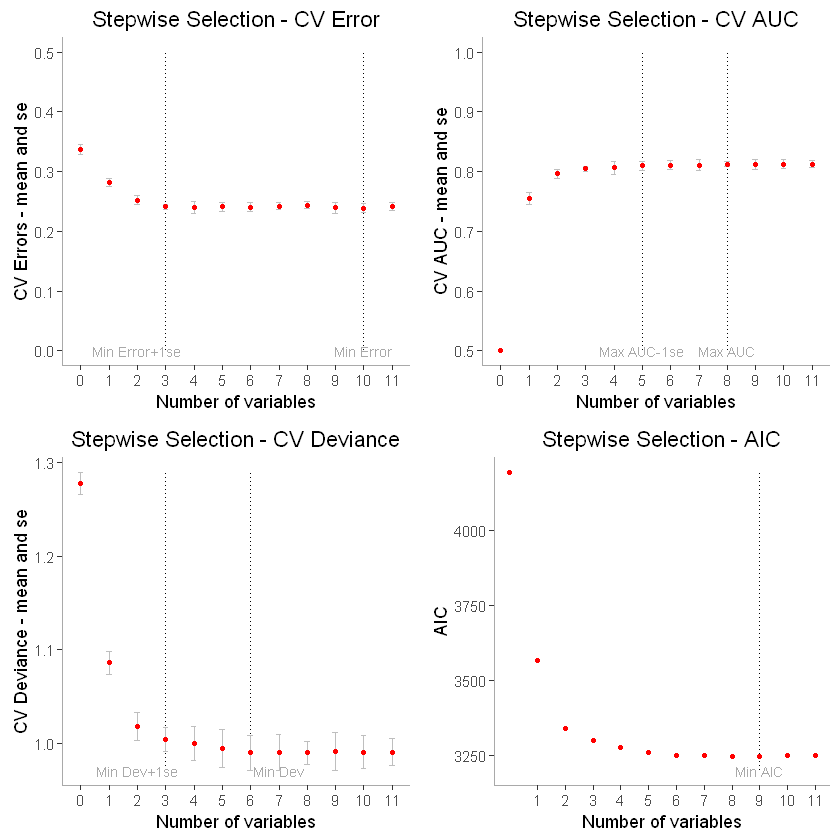

In [9]:
# Plot the Cross-Validation misclassification error
p1 <- ggplot(step.error.plot,aes(x=nVars,y=y,ymin=ymin,ymax=ymax)) +
      geom_linerange(aes(x=nVars[step.errmin],ymin=0,ymax=0.5),linetype=3) +
      annotate("text", x=step.error.plot$nVars[step.errmin], y=0, label = "Min Error", colour = "darkgrey", size = 3) +
      geom_linerange(aes(x=nVars[step.err1se],ymin=0,ymax=0.5),linetype=3) +
      annotate("text", x=step.error.plot$nVars[step.err1se]-1, y=0, label = "Min Error+1se", colour = "darkgrey", size = 3) +
      geom_errorbar(width=0.2, colour="grey") +
      geom_point(colour="red",size=1) +
      scale_x_continuous("Number of variables",breaks=seq(0,max(step.error.plot$nVars))) +
      ylab("CV Errors - mean and se") +
      ggtitle("Stepwise Selection - CV Error") +
      theme(axis.line.x = element_line(colour = "darkgrey"),
            axis.line.y = element_line(colour = "darkgrey"),
            panel.background = element_blank())

# Plot the Cross-validation AUC
p2 <- ggplot(step.auc.plot,aes(x=nVars,y=y,ymin=ymin,ymax=ymax)) +
      geom_linerange(aes(x=nVars[step.aucmax],ymin=0.5,ymax=1),linetype=3) +
      annotate("text", x=step.auc.plot$nVars[step.aucmax], y=0.5, label = "Max AUC", colour = "darkgrey", size = 3) +
      geom_linerange(aes(x=nVars[step.auc1se],ymin=0.5,ymax=1),linetype=3) +
      annotate("text", x=step.auc.plot$nVars[step.auc1se], y=0.5, label = "Max AUC-1se", colour = "darkgrey", size = 3) +
      geom_errorbar(width=0.2, colour="grey") +
      geom_point(colour="red",size=1) +
      scale_x_continuous("Number of variables",breaks=seq(0,max(step.auc.plot$nVars))) +
      ylab("CV AUC - mean and se") +
      ggtitle("Stepwise Selection - CV AUC") +
      theme(axis.line.x = element_line(colour = "darkgrey"),
            axis.line.y = element_line(colour = "darkgrey"),
            panel.background = element_blank())

# Plot the Cross-validation deviance
p3 <- ggplot(step.dev.plot,aes(x=nVars,y=y,ymin=ymin,ymax=ymax)) +
  geom_linerange(aes(x=nVars[step.devmin],ymin=min(ymin),ymax=max(ymax)),linetype=3) +
  annotate("text", x=step.dev.plot$nVars[step.devmin]+1, y=min(step.dev.plot$ymin), label = "Min Dev", colour = "darkgrey", size = 3) +
  geom_linerange(aes(x=nVars[step.dev1se],ymin=min(ymin),ymax=max(ymax)),linetype=3) +
  annotate("text", x=step.dev.plot$nVars[step.dev1se]-1, y=min(step.dev.plot$ymin), label = "Min Dev+1se", colour = "darkgrey", size = 3) +
  geom_errorbar(width=0.2, colour="grey") +
  geom_point(colour="red",size=1) +
  scale_x_continuous("Number of variables",breaks=seq(0,max(step.dev.plot$nVars))) +
  ylab("CV Deviance - mean and se") +
  ggtitle("Stepwise Selection - CV Deviance") +
  theme(axis.line.x = element_line(colour = "darkgrey"),
        axis.line.y = element_line(colour = "darkgrey"),
        panel.background = element_blank())

# Plot the AIC
aicmin=which.min(step.result$AIC)
p4 <- ggplot(data.frame(nVars=seq(0,11),y=step.result$AIC),aes(x=nVars,y=y)) +
      geom_linerange(aes(x=aicmin,ymin=3200,ymax=step.result$AIC[1]),linetype=3) +
      annotate("text", x=aicmin, y=3200, label = "Min AIC", colour = "darkgrey", size = 3) +
      geom_point(colour="red",size=1) +
      scale_x_continuous("Number of variables",breaks=seq(1,nrow(step.result))) +
      ylab("AIC") +
      ggtitle("Stepwise Selection - AIC") +
      theme(axis.line.x = element_line(colour = "darkgrey"),
            axis.line.y = element_line(colour = "darkgrey"),
            panel.background = element_blank())

# Display the plots
grid.arrange(p1, p2, p3, p4, ncol=2, nrow=2)

The above plots show that very similar results were obtained for the models with three or more variables. All the plots show higher error rates with less than three variables, indicating that these models are biased and so will tend to under-fit the data. Although the error has started to increase when all eleven variables are used, it has not increased significantly. This means that the model variance is still low and so even the eleven variable model is unlikely to over-fit the data.

The model with six variables is the best stepwise selection model based on the deviance measure. The model with three variables is the smallest model with the mean deviance within one standard error of the best model, and so is likely to give good results and is a simpler model. Both these models will later be evaluated using the testing dataset to determine the best overall model.

#### Build the Best Model based on Stepwise Selection

*Train the best step-wise selection models on the full training dataset.*

In [10]:
# Extract the formula
step.min.formula <- step.result$formula[step.devmin]
step.1se.formula <- step.result$formula[step.dev1se]

# Build the model using all the training data
wine.step.min <- glm(step.min.formula, data=wine.train, family="binomial")
wine.step.1se <- glm(step.1se.formula, data=wine.train, family="binomial")

# Display the coefficients
cbind(step.min=coef(wine.step.min),
      step.1se=rbind(data.frame(step.dev1se=coef(wine.step.1se)),data.frame(step.dev1se=c(NA,NA,NA))))

,step.min,step.dev1se
(Intercept),-8.943936,-9.0566
alcohol,1.122666,1.0884
volatile.acidity,-6.888461,-6.7968
residual.sugar,0.054850,0.0601
fixed.acidity,-0.228181,NA
sulphates,1.749092,NA
free.sulfur.dioxide,0.008893,NA


#### Stepwise Selection - Summary

In summary, the best model obtained using forward stepwise selection includes six variables. In decreasing order of importance the selected variables are: alchohol, volatile.acidity, residual.sugar, fixed.acidity, sulphates and free.sulfur.dioxide. The model with the fewest variables that is within one standard error of the best model includes three variables (alchohol, volatile.acidity and residual.sugar).

The assumption behind using the "one-standard-error" model is that it should show similar performance to the best model when evaluated using the test data. If this assumption holds (so the model is not under-fitting), then the "one-standard-error" model is preferred as it is a less complex model and so is less likely to over-fit and it is more explainable than the "minimum deviance" model.

### Ridge Regularisation

The next method used to develop a logistic regression model for the Wine Quality data is ridge regularisation. This method adds a penalty term to the loss function (that is minimized when calculating the coefficients) to constrain the coefficients, or shrink them towards zero. The penalty term is controlled by the tuning parameter $\lambda$ (lambda) - the larger $\lambda$ is, the heavier the penalty and so the coefficients of the least important variables tend to zero. The shrinkage penalty used by ridge regression is based on the $l_2$ norm and is $\lambda\sum_{j=1}^p {\beta_j}^2$, where $p$ is the number of predictor variables and $\beta_j$ is the coefficient of the $j^{th}$ predictor variable.

Ridge regression uses all the predictor variables but the coefficients approach zero as $\lambda$ tends to $\infty$. This constraint of the coefficients decreases the effective degrees of freedom of the model (Breheny, 2011), so the value of $\lambda$ controls the bias/variance trade-off. If $\lambda$ is zero, no regularization penalty is applied and the standard logistic regression model using all variables is fit; this model potentially has high variance and is liable to over-fitting. As $\lambda$ increases and the model becomes more constrained, the variance decreases but the bias increases; so if $\lambda$ is too large the model will be prone to under-fitting.

To find the best ridge regularisation model with the optimum bias/variance trade-off, the value of $\lambda$ needs to optimised. This is done by fitting models with a range of values for $\lambda$ and using k-fold cross-validation (with the number of folds $k$ set to the default of $10$) to estimate the test deviance. The best model can then be selected by finding the $\lambda$ with the lowest deviance.

In [11]:
# Format predictor and response variables for glmnet and cv.glmnet
X <- model.matrix(quality ~ .,data=wine.train)[,-1]
y <- wine.train$quality

#### Use Cross-Validation to Find the Optimal Lambda

*Run the cross-validated ridge regularisation using the default lambda values*

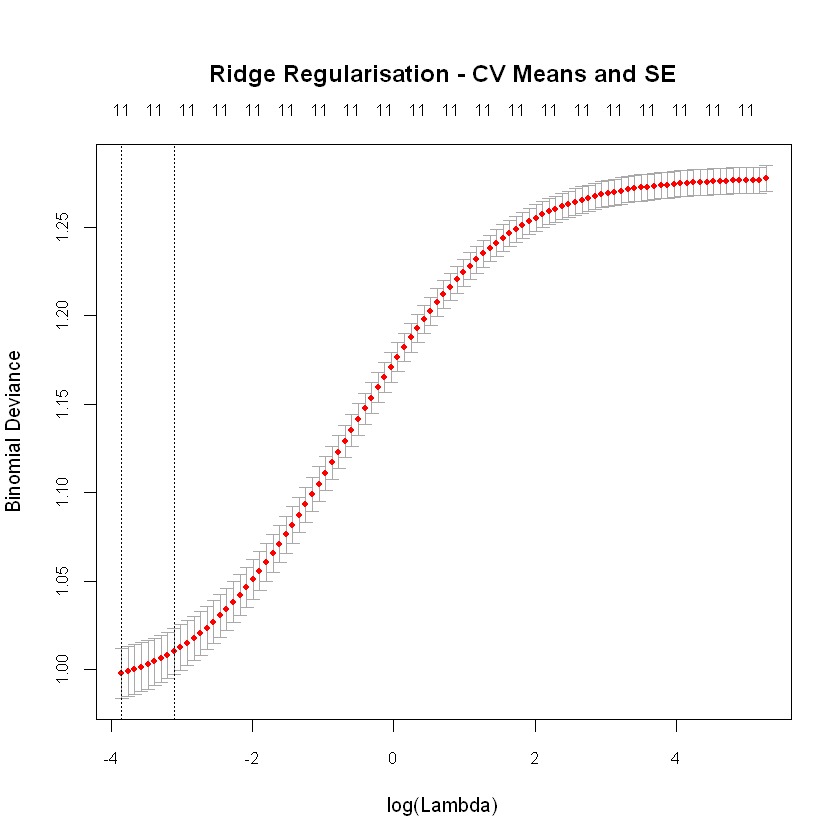

In [12]:
# Run the ridge regression using k-fold cross-validation and default lambda range
wine.ridge.cv <- cv.glmnet(X, y, alpha=0, family="binomial")

# Plot the deviance for each lambda
par(cex.axis=0.8,mar=c(5, 4, 6, 2))
plot(wine.ridge.cv,main="Ridge Regularisation - CV Means and SE")

*This shows the best lambda being the smallest lambda tried, so try again using a range for lambda that include smaller values.*

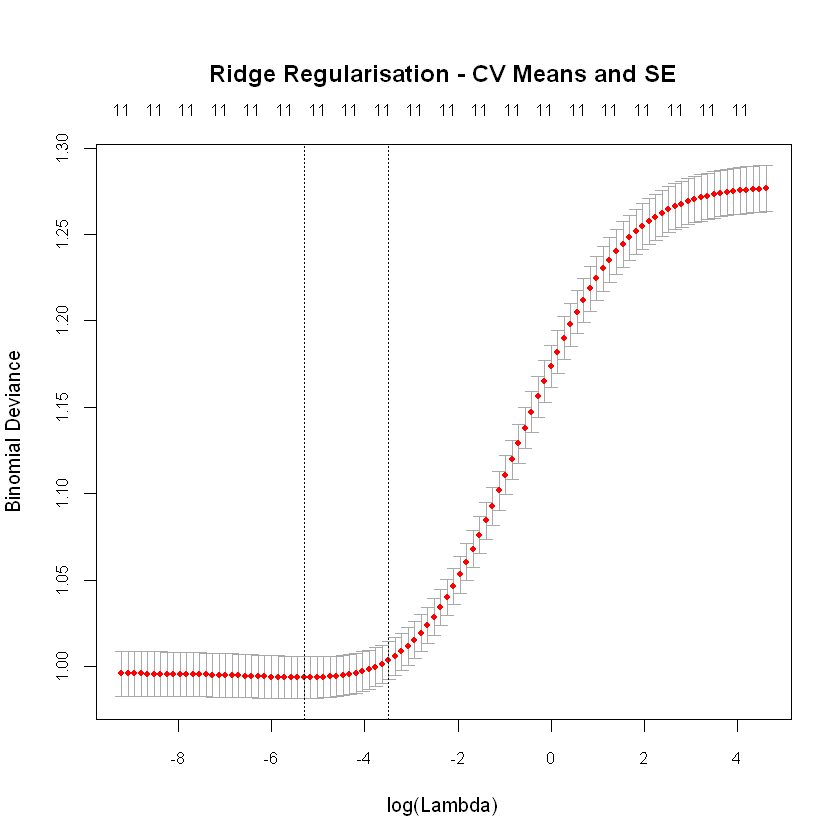

In [13]:
# Grid of regularisation values (lambda)
grid <- 10^seq(2,-4,length=100)

# Ridge regression with k-fold cross-validation
wine.ridge.cv <- cv.glmnet(X, y, alpha=0, lambda=grid, family="binomial" )

# Plot the deviance for each lambda
par(cex.axis=0.8,mar=c(5, 4, 6, 2))
plot(wine.ridge.cv,main="Ridge Regularisation - CV Means and SE")

#### Compare Models for Different Lambdas

*Run the ridge regularisation on the full training dataset*

In [14]:
# Ridge Regression
wine.ridge <- glmnet(X, y, alpha=0, lambda=grid, family="binomial" )

*Display model coefficients for largest and smallest lambda, plus the best fit and the one-standard-error fit*

In [15]:
ridge.summ <- as.matrix(cbind(coef(wine.ridge, s=grid[1]),
                              coef(wine.ridge, s=wine.ridge.cv$lambda.1se),
                              coef(wine.ridge, s=wine.ridge.cv$lambda.min),
                              coef(wine.ridge, s=grid[100])))
lambdas <- c(grid[1], wine.ridge.cv$lambda.1se, wine.ridge.cv$lambda.min, grid[100])
colnames(ridge.summ) <- c("largest", "one-se", "best fit", "smallest")
print(rbind(lambda=lambdas, ridge.summ))

                           largest     one-se    best fit    smallest
lambda               100.000000000   0.030539    0.004977    0.000100
(Intercept)            1.125324903  82.173461  109.338886  141.063363
fixed.acidity         -0.000556502  -0.101678   -0.096313   -0.076030
volatile.acidity      -0.010651382  -4.784868   -6.047768   -6.437198
citric.acid            0.000079791   0.407973    0.367927    0.353839
residual.sugar        -0.000106331   0.058288    0.095155    0.115852
chlorides             -0.040619331  -3.976668   -1.535322   -0.561500
free.sulfur.dioxide   -0.000002206   0.009728    0.011077    0.011061
total.sulfur.dioxide  -0.000019797  -0.002497   -0.002106   -0.001803
density               -0.466227010 -90.641993 -120.900836 -153.942728
pH                     0.003334492   0.822604    1.009579    1.149589
sulphates              0.002607244   1.440145    1.810688    1.951528
alcohol                0.001583947   0.677019    0.874642    0.910971


The above display of the model coefficients shows that as the regularisation penalty (lambda) increases, the coefficients for each variable generally decrease.

Of particular interest are the large changes in the coefficients for the intercept and density, which grow at a similar rate, but with the opposite sign, suggesting that these are to some extent cancelling each other out.

*To investigate what is happening, display the distribution of values for "density" in a boxplot.*

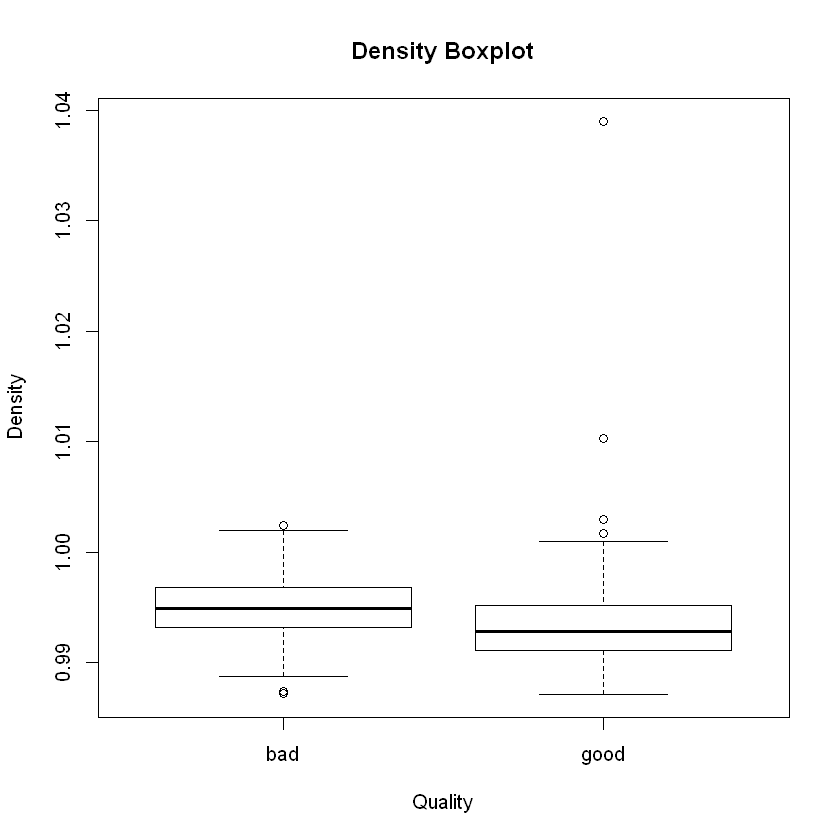

In [16]:
# Boxplot of density for each quality category
boxplot(wine.train$density ~ wine.train$quality, main="Density Boxplot", ylab="Density", xlab="Quality")

The boxplot of "density" above shows there is very little difference between the density distribution for "bad" and "good" quality wines - apart from a few outliers for "good". The range of values that the majority of observations take is very narrow, with less than two percent difference between the whiskers of each boxplot. This suggests that the logistic regression algorithm is having difficulty fitting the coefficient for density - with the outliers forcing a coefficient that is too large for most of the values, so the algorithm then increases the intercept to compensate. Regularisation limits this conflict and is therefore particularly effective in shrinking the density coefficient and intercept term.  

#### Visualise the Coefficients

*Plot the coefficients over all values of lambda*

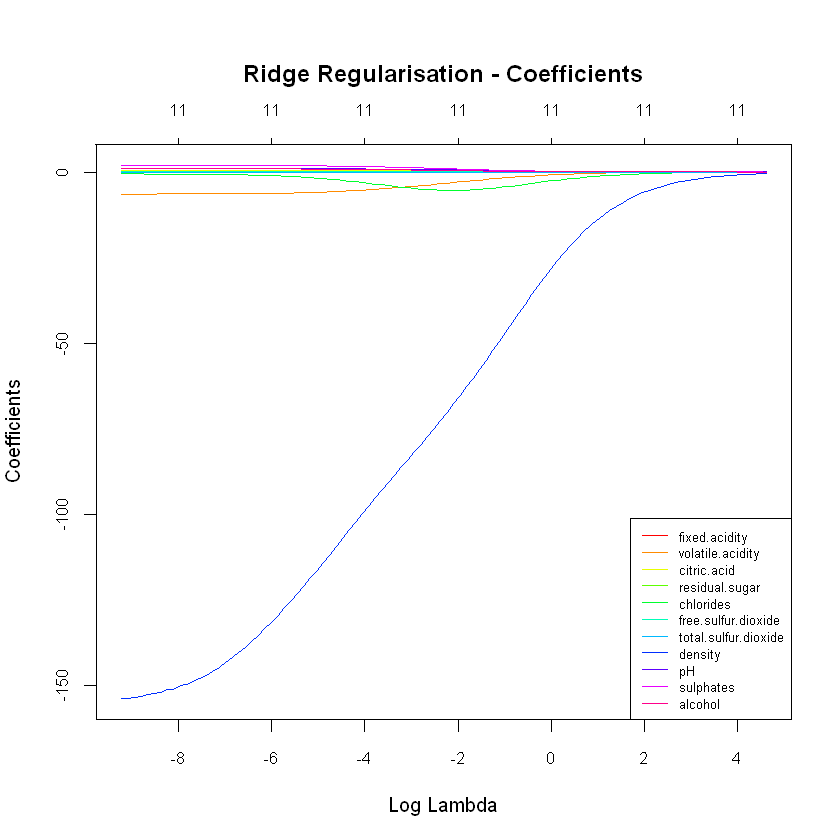

In [17]:
par(cex.axis=0.8, mar=c(5, 4, 6, 2))
plot(wine.ridge, xvar="lambda", main="Ridge Regularisation - Coefficients", col=rainbow(11))
legend("bottomright", legend=names(wine.train)[1:11], col=rainbow(11), lty=1, cex=0.65)

The way the "density" coefficient dominates the model can be seen in the above plot. Although it rapidly drops towards zero as lambda increases, it is still the largest coefficient even for comparatively large values of lambda.

As the scale required to plot large density coefficient obscures the detail of how the coefficients behave at they approach zero, the following plot provides a close-up view of this part of the plot. The lambda-min and lambda-1se locations are also shown.

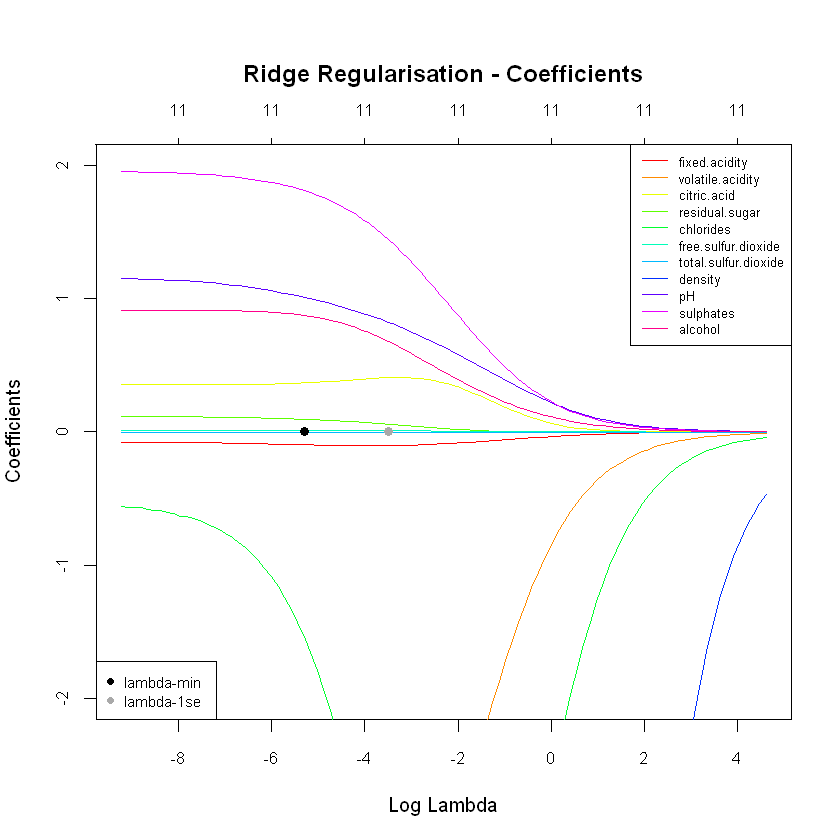

In [18]:
par(cex.axis=0.8, mar=c(5, 4, 6, 2))
# plot the ridge regularisation limiting the display range of the coefficients
plot(wine.ridge, xvar="lambda", ylim=c(-2,2), main="Ridge Regularisation - Coefficients", col=rainbow(11))
# plot lambda-1se
points(x=log(wine.ridge.cv$lambda.1se), y=0, pch=19, col="Darkgrey")
# plot lambda-min
points(x=log(wine.ridge.cv$lambda.min), y=0, pch=19, col="Black")
# add some legends
legend("bottomleft", legend=c("lambda-min","lambda-1se"), col=c("Black","Darkgrey"), pch=19, cex=0.75)
legend("topright", legend=names(wine.train)[1:11], col=rainbow(11), lty=1, cex=0.65)

This plot shows that all the coefficients are pushed towards zero as lambda increases, but none of them actually reach zero. With ridge regularisation all the variables stay in the model even when lambda is large.

#### Ridge Regularisation - Summary

In summary, the best model obtained using ridge regularisation has constrained the coefficients of the predictor variables. This is particularly noticeable with the intercept and the density variable, which have large coefficients with opposite signs when unconstrained. The "one-standard-error model" (with $\lambda = 0.0305$) constrains these values substantially more than the minimum error model ($\lambda = 0.0050$).

As with the forward stepwise selection model, both the "minimum deviance" and "one-standard-error" models will be evaluated using the test data. If the assumption that the "one-standard-error" model is not biased holds (so the model is not under-fitting), then this model is preferred as it is has fewer effective degrees of freedom (Breheny, 2011) and so is less likely to over-fit than the "minimum deviance" model.

### Lasso Regularisation

The final method used to develop a logistic regression model for the Wine Quality data is lasso regularisation. Like ridge regularisation, this method adds a penalty term to the loss function to constrain the coefficents, which helps prevent the model over-fitting. But unlike ridge regularisation, lasso regularisation allows the coefficients of the predictor variables to reach zero, which removes them from the model. This means that lasso regularisation will perform variable selection as well as constrain the coefficients.

The shrinkage penalty used by lasso regression is based on the $l_1$ norm and is $\lambda\sum_{j=1}^p |\beta_j|$, where $p$ is the number of predictor variables and $\beta_j$ is the coefficient of the $j^{th}$ predictor variable. The penalty term is controlled by the tuning parameter $\lambda$ - the larger $\lambda$ is, the heavier the penalty and so the coefficients of the least important variables will reduce to zero.

The value of $\lambda$ controls the bias/variance trade-off. If $\lambda$ is zero, no regularization penalty is applied and the standard logistic regression model using all variables is fit. This model has the highest variance and is liable to over-fitting. As $\lambda$ increases the model becomes more constrained and more variables are removed, decreasing the degrees of freedom of the model. Therefore, the variance will decrease but the bias will increase; so if $\lambda$ is too large the model will be prone to under-fitting.

To find the best lasso regularisation model, the value of $\lambda$ needs to optimised. As was done for ridge regularisation, models are fitted using a range of values for $\lambda$ and k-fold cross-validation (using the default of $10$ folds) is used to estimate the test deviance. The best model can then be selected by finding the $\lambda$ with the lowest deviance.

#### Use Cross-Validation to Find the Optimal Lambda

*Run the cross-validated lasso regularisation using the default lambda values*

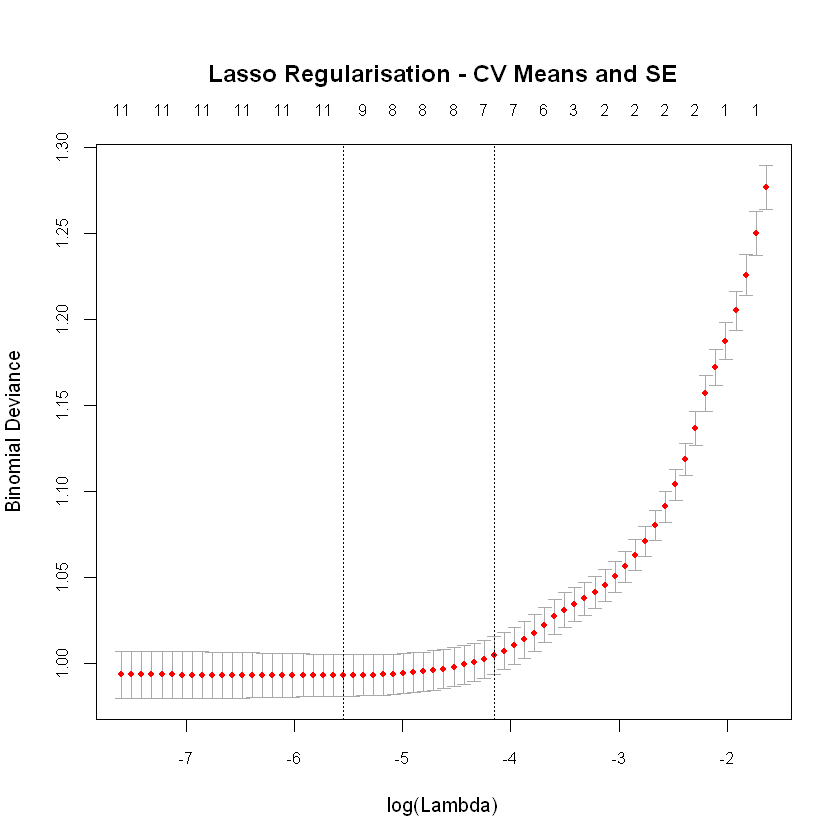

In [19]:
# Run the lasso regression using k-fold cross-validation
wine.lasso.cv <- cv.glmnet(X, y, alpha=1, family="binomial")

# Plot the deviance for each lambda
par(cex.axis=0.8, mar=c(5, 4, 6, 2))
plot(wine.lasso.cv, main="Lasso Regularisation - CV Means and SE")

*The largest value of lambda still has one variable, so try with a range of lambdas that include models with zero variables*

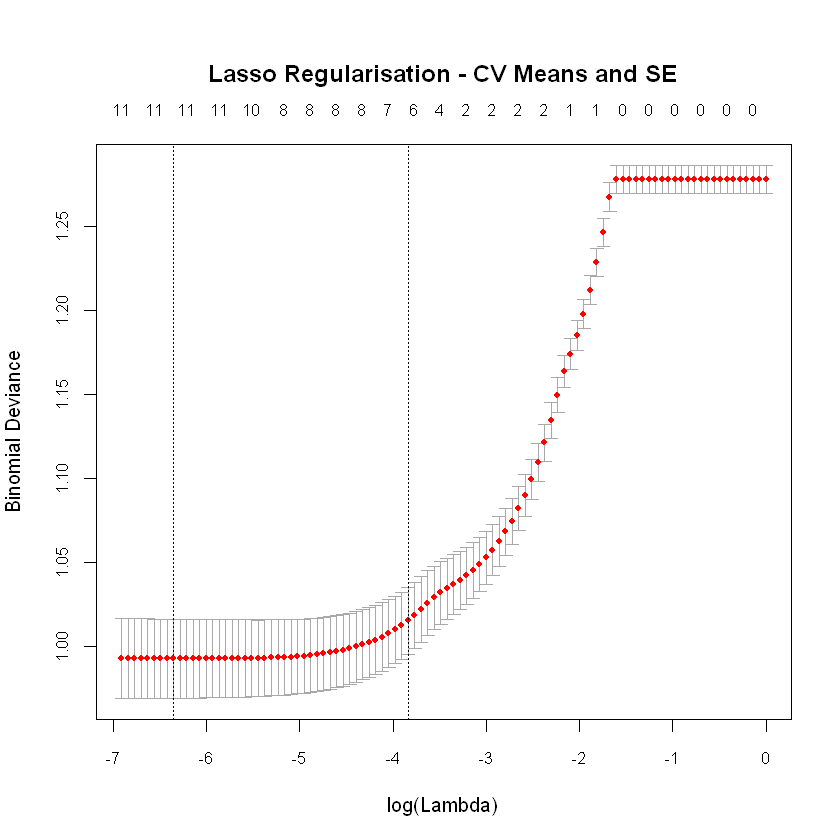

In [20]:
# Grid of regularisation values (lambda)
grid <- 10^seq(0, -3, length=100)

# Lasso Regression with k-fold cross-validation
wine.lasso.cv <- cv.glmnet(X, y, alpha=1, lambda=grid, family="binomial")

# Plot the deviance for each lambda
par(cex.axis=0.8, mar=c(5, 4, 6, 2))
plot(wine.lasso.cv, main="Lasso Regularisation - CV Means and SE")

#### Compare Models for Different Lambdas

*Run the lasso regularisation on the full training dataset*

In [21]:
wine.lasso <- glmnet(X, y, alpha=1, lambda=grid, family="binomial")

*Display model coefficients for largest and smallest lambda, plus the best fit and the one-standard-error fit*

In [22]:
lasso.summ <- as.matrix(cbind(coef(wine.lasso, s=grid[1]),
                              coef(wine.lasso, s=wine.lasso.cv$lambda.1se),
                              coef(wine.lasso, s=wine.lasso.cv$lambda.min),
                              coef(wine.lasso, s=grid[100])))
lambdas <- c(grid[1], wine.lasso.cv$lambda.1se, wine.lasso.cv$lambda.min, grid[100])
colnames(lasso.summ) <- c("largest", "one-se", "best fit", "smallest")
print(rbind(lambda=lambdas, lasso.summ))

                     largest    one-se   best fit    smallest
lambda                1.0000  0.021544   0.001748    0.001000
(Intercept)           0.6786 -6.430111  55.578348   89.293784
fixed.acidity         0.0000 -0.074068  -0.130251   -0.109078
volatile.acidity      0.0000 -4.771211  -6.388798   -6.411623
citric.acid           0.0000  0.000000   0.200885    0.265157
residual.sugar        0.0000  0.011298   0.078675    0.093741
chlorides             0.0000  0.000000  -0.700767   -0.635128
free.sulfur.dioxide   0.0000  0.002771   0.010053    0.010488
total.sulfur.dioxide  0.0000  0.000000  -0.001353   -0.001553
density               0.0000  0.000000 -66.799532 -101.200614
pH                    0.0000  0.024287   0.765454    0.921097
sulphates             0.0000  0.378289   1.678099    1.791699
alcohol               0.0000  0.821252   0.990411    0.960586


This shows that as $\lambda$ increases, the coefficients of some variables are set to zero, removing the variables from the model. At the "minimum deviance" $\lambda$ ($0.0017$), all variables are still in the model, but at the "one-standard-error" $\lambda$ ($0.0215$) four variables have been removed from the model. This includes removing "density", which for the smallest values of lambda had the largest coefficient.

#### Variable Selection Analysis

*Next, look at the order the variables are added to the model as lambda decreases and compare these to the order stepwise variable selection added them.*

In [23]:
# Find the maximum lambda for each variable, ignoring the intercept
# Extract the coefficients for all values of lambda
lasso.coef <- as.data.frame(as.matrix(cbind(lambda=grid, t(wine.lasso$beta))))

# A dataframe for the results
lasso.vars <- data.frame(lasso.order=names(lasso.coef[2:12]), max.lambda=0)

# Loop through the variables, ignoring the intercept
for (i in 2:12) {
    # Loop though the lambda values
    for (j in 1:100) {
        # When the first non-zero coefficient is found ...
        if (lasso.coef[j,i] != 0) {
            # ... save the lambda ...
            lasso.vars$max.lambda[i-1] <- lasso.coef[j,1]
            # ... and move on to the next variable
            break()
        }
    }
}

# Sort the variables in decreasing order of removal
cbind(lasso.vars[order(lasso.vars$max.lambda, decreasing=TRUE),],
      # add in the stepwise selection order
      stepwise.order=step.result$nextTerm[2:nrow(step.result)])

,lasso.order,max.lambda,stepwise.order
11,alcohol,0.187382,alcohol
2,volatile.acidity,0.107227,volatile.acidity
1,fixed.acidity,0.032745,residual.sugar
6,free.sulfur.dioxide,0.030539,fixed.acidity
10,sulphates,0.028480,sulphates
4,residual.sugar,0.026561,free.sulfur.dioxide
9,pH,0.021544,pH
5,chlorides,0.013219,density
7,total.sulfur.dioxide,0.005337,total.sulfur.dioxide
3,citric.acid,0.004329,citric.acid


As both lasso regularisation and stepwise selection perform variable selection the order that each method adds/removes variables is compared. The table above lists the order that these methods add/remove variables from the model (with the most important variable first). It shows:
- Both lasso regularisation and stepwise variable selection determined that "alcohol" and "volatile.acidity" were the most important variables.
- The four variables lasso does not include in the "one-standard-error" model (chlorides, total.sulfur.dioxide, citric.acid and density) are the last four variables that stepwise variable selection added to the model - although they are added/removed in a different order.
- Lasso adds "Density" last, so lasso regularisation not only stops this variable from dominating the model but determines that it is not needed to predict wine quality.

#### Visualise the Coefficients

*Plot the coefficients over all values of lambda to visualise the changes to the coefficients as lambda increases.*

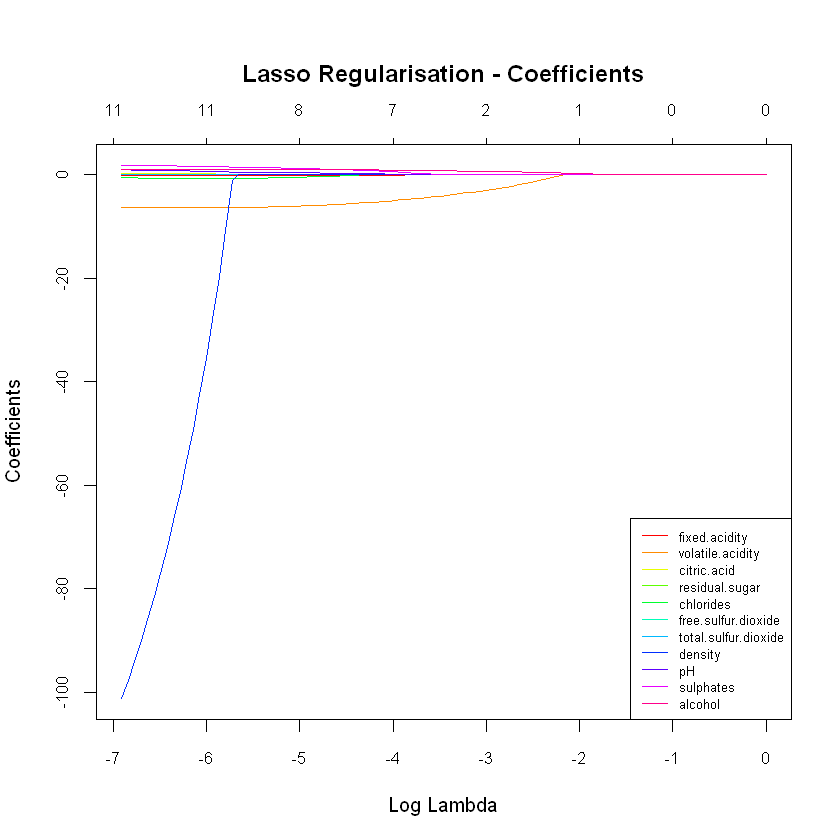

In [24]:
par(cex.axis=0.8, mar=c(5, 4, 6, 2))
plot(wine.lasso, xvar="lambda", main="Lasso Regularisation - Coefficients", col=rainbow(11))
legend("bottomright", legend=names(wine.train)[1:11], col=rainbow(11), lty=1, cex=0.65)

As was the case with ridge regularisation, "density" is dominating the model at small values of $\lambda$, but the lasso regularisation pushes it towards zero much faster than ridge regularisation did.

As the scale required to plot large density coefficient obscures the detail of how the coefficients behave at they reduce to zero, the following plot provides a close-up view of this part of the plot. The lambda-min and lambda-1se locations are also shown.

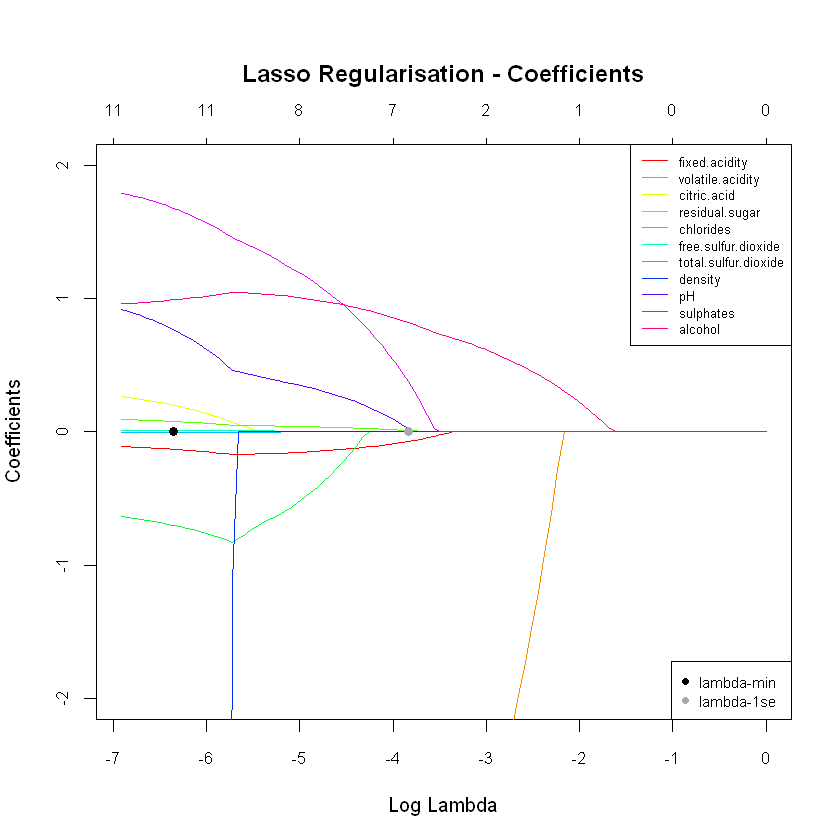

In [25]:
par(cex.axis=0.8, mar=c(5, 4, 6, 2))
# plot the lasso regularisation limiting the display range of the coefficients
plot(wine.lasso, xvar="lambda", ylim=c(-2,2), main="Lasso Regularisation - Coefficients", col=rainbow(11))
# plot lambda-1se
points(x=log(wine.lasso.cv$lambda.1se), y=0, pch=19, col="Darkgrey")
# plot lambda-min
points(x=log(wine.lasso.cv$lambda.min), y=0, pch=19, col="Black")
# add some legends
legend("bottomright", legend=c("lambda-min","lambda-1se"), col=c("Black","Darkgrey"), pch=19, cex=0.75)
legend("topright", legend=names(wine.train)[1:11], col=rainbow(11), lty=1, cex=0.65)

This plot shows that all the coefficients are pushed towards zero as $\lambda$ increases. When $\lambda > 0.003$, coefficients start to reach to zero and variables are removed from the model. For values of $\lambda > 0.19$ all coefficients are zero and the model uses the intercept only. Lasso regularisation is performing variable selection as well as regularising the coefficients.

#### Lasso Regularisation - Summary

In summary, the best model obtained using lasso regularisation has constrained the coefficients of the predictor variables. As with ridge regularisation, this is particularly noticeable with the coefficients for the intercept and the density variable. The minimum error model (with $\lambda = 0.0017$) uses all the variables, but the "one-standard-error" model (with $\lambda = 0.0215$) removes four variables including density from the model, which results in a substantial reduction in the intercept value.

As for the other methods, both the "minimum deviance" and "one-standard-error" models will be evaluated using the test data. If the assumption that the "one-standard-error" model is not biased holds (so the model is not under-fitting), then this model is preferred as it is has fewer variables and so is both simpler (more explainable) and less likely to over-fit than the "minimum deviance" model.

### Model Comparison

#### Compare the Model Coefficients

*Compare the coefficients for the best model from the stepwise selection, ridge regularisation and lasso regularisation with the full model without regularisation or variable selection.*

In [26]:
# Generate the full model without regularisation for comparison
full.model <- glm(quality ~ ., data=wine.train, family="binomial")

# Format the stepwise coefficients into a dataframe that includes all variables
step.coef.min <- merge(data.frame(rownums=seq(1:(ncol(wine.train)-1)), nextTerm=names(wine.train[1:(ncol(wine.train)-1)])),
                       data.frame(coef=coef(wine.step.min)),
                       by.x="nextTerm",by.y="row.names",all.x=TRUE,all.y=TRUE)
row.names(step.coef.min) <- step.coef.min$nextTerm
step.coef.min <- step.coef.min[order(step.coef.min$rownums,na.last=FALSE),]

step.coef.1se <- merge(data.frame(rownums=seq(1:(ncol(wine.train)-1)), nextTerm=names(wine.train[1:(ncol(wine.train)-1)])),
                       data.frame(coef=coef(wine.step.1se)),
                       by.x="nextTerm",by.y="row.names",all.x=TRUE,all.y=TRUE)
row.names(step.coef.1se) <- step.coef.1se$nextTerm
step.coef.1se <- step.coef.1se[order(step.coef.1se$rownums,na.last=FALSE),]

# Format the lasso coefficients by setting zeros to NA
lasso.coef.min <- as.vector(coef(wine.lasso, s=wine.lasso.cv$lambda.min))
is.na(lasso.coef.min) <- lasso.coef.min==0
lasso.coef.1se <- as.vector(coef(wine.lasso, s=wine.lasso.cv$lambda.1se))
is.na(lasso.coef.1se) <- lasso.coef.1se==0

# Display coefficients for the full model ...
data.frame(full=coef(full.model),
           # ... the stepwise models
           stepwise.min=step.coef.min$coef,
           stepwise.1se=step.coef.1se$coef,
           # ... the ridge regularisation models
           ridge.min=as.vector(coef(wine.ridge, s=wine.ridge.cv$lambda.min)),
           ridge.1se=as.vector(coef(wine.ridge, s=wine.ridge.cv$lambda.1se)),
           # ... and the lasso regularisation models
           lasso.min=lasso.coef.min,
           lasso.1se=lasso.coef.1se)

,full,stepwise.min,stepwise.1se,ridge.min,ridge.1se,lasso.min,lasso.1se
(Intercept),145.782327,-8.943936,-9.0566,109.338886,82.173461,55.578348,-6.430111
fixed.acidity,-0.072313,-0.228181,NA,-0.096313,-0.101678,-0.130251,-0.074068
volatile.acidity,-6.446387,-6.888461,-6.7968,-6.047768,-4.784868,-6.388798,-4.771211
citric.acid,0.354210,NA,NA,0.367927,0.407973,0.200885,NA
residual.sugar,0.117954,0.054850,0.0601,0.095155,0.058288,0.078675,0.011298
chlorides,-0.512773,NA,NA,-1.535322,-3.976668,-0.700767,NA
free.sulfur.dioxide,0.011029,0.008893,NA,0.011077,0.009728,0.010053,0.002771
total.sulfur.dioxide,-0.001774,NA,NA,-0.002106,-0.002497,-0.001353,NA
density,-158.759117,NA,NA,-120.900836,-90.641993,-66.799532,NA
pH,1.167910,NA,NA,1.009579,0.822604,0.765454,0.024287


The above table shows the coefficients of all the models considered plus the full, unconstrained model. The effects of variable selection and regularisation are most clearly seen by considering the intercept and density terms:
- Without variable selection or regularisation, the intercept and the density coefficients go to large positive and negative values respectively. As shown in the previous boxplot of density, most values of density lie within a narrow range, so the net effect is that these two terms largely cancel each other out.
- Neither the stepwise models or the "one-standard-error" lasso models include density in the model. This helps keep the intercept close to zero.
- Lasso regularisation is able to constrain the intercept and density coefficient for values of $\lambda$ near the value where density is dropped.
- Ridge regularisation is able to constrain the intercept and density coefficient significantly compared to the full model, but does not eliminate it completely.

#### Compare the Model Deviances

*Use the deviance returned from the cross-validation run for variable selection/lambda tuning to compare how well the best models for each method perfrom.*

In [27]:
# Print the mean deviance for each of the selected models
cat(sprintf("Step-wise selection - minimum deviance model (%d variables):      %1.4f\n",
            step.devmin-1, step.result$Deviance.mean[step.devmin]))
cat(sprintf("Step-wise selection - one-standard-error model (%d variables):    %1.4f\n",
            step.dev1se-1, step.result$Deviance.mean[step.dev1se]))
cat(sprintf("Ridge regularisation - minimum deviance model (lambda=%1.4f):   %1.4f\n",
            wine.ridge.cv$lambda.min, wine.ridge.cv$cvm[which(wine.ridge.cv$lambda==wine.ridge.cv$lambda.min)]))
cat(sprintf("Ridge regularisation - one-standard-error model (lambda=%1.4f): %1.4f\n",
            wine.ridge.cv$lambda.1se, wine.ridge.cv$cvm[which(wine.ridge.cv$lambda==wine.ridge.cv$lambda.1se)]))
cat(sprintf("Lasso regularisation - minimum deviance model (lambda=%1.4f):   %1.4f\n",
            wine.lasso.cv$lambda.min, wine.lasso.cv$cvm[which(wine.lasso.cv$lambda==wine.lasso.cv$lambda.min)]))
cat(sprintf("Lasso regularisation - one-standard-error model (lambda=%1.4f): %1.4f\n",
            wine.lasso.cv$lambda.1se, wine.lasso.cv$cvm[which(wine.lasso.cv$lambda==wine.lasso.cv$lambda.1se)]))

Step-wise selection - minimum deviance model (6 variables):      0.9900
Step-wise selection - one-standard-error model (3 variables):    1.0047
Ridge regularisation - minimum deviance model (lambda=0.0050):   0.9938
Ridge regularisation - one-standard-error model (lambda=0.0305): 1.0036
Lasso regularisation - minimum deviance model (lambda=0.0017):   0.9929
Lasso regularisation - one-standard-error model (lambda=0.0215): 1.0155


Comparing the deviance of the best models of each type based on the cross-validation results shows the difference between the three "minimum deviance" models is less than 0.4 percent. There is a slightly larger variation in the deviances on the "one-standard-error" models. The stepwise selection and ridge regularisation model deviances are very similar; but the deviance on the lasso regularisation model is about one percent higher.

These results mean that based on the results of the cross-validation used to build the models, no one model stands out at being the best model.

### Model Testing

To find the overall best model, the models built using stepwise selection, ridge regularisation and lasso regularisation are evaluated using the test dataset. Each model is used to determine the probability that each wine in the test set is "good" quality and the results evaluated using the accuracy, AUC and deviance measures.

These results are then analysed to review how each model behaved and to determine which model produces the best result.

*Test the best models found by stepwise selection, ridge regularisation and lasso regularisation to determine the best overall model based on the test data. Uses the testModel function to calculate the accuracy, AUC and deviance of each model based on the test data.*

In [28]:
# Read the testing data
wine.test <- read.csv("Wine_testing.csv")

# Format into X and Y for glmnet
test.X <- as.matrix(wine.test[,-12])
test.y <- wine.test$quality

# Test the stepwise model with minimum deviance
step.test <- testModel(wine.step.min, wine.test[,-12], test.y, CI=TRUE)
cat(sprintf("\nStepwise selection - minimum deviance (%d variables):       accuracy = %1.4f (CI = %1.4f - %1.4f)\n",
            step.devmin-1, step.test$accuracy$mean, step.test$accuracy$lower, step.test$accuracy$upper))
cat(sprintf("                                                           AUC = %1.4f (CI = %1.4f - %1.4f)\n",
            step.test$AUC$mean, step.test$AUC$lower, step.test$AUC$upper))
cat(sprintf("                                                           deviance = %1.4f (CI = %1.4f - %1.4f)\n",
            step.test$deviance$mean, step.test$deviance$lower, step.test$deviance$upper))

# Test the one-standard-error stepwise model
step.test <- testModel(wine.step.1se, wine.test[,-12], test.y, CI=TRUE)
cat(sprintf("\nStepwise selection - one-standard-error (%d variables):     accuracy = %1.4f (CI = %1.4f - %1.4f)\n",
            step.dev1se-1, step.test$accuracy$mean, step.test$accuracy$lower, step.test$accuracy$upper))
cat(sprintf("                                                           AUC = %1.4f (CI = %1.4f - %1.4f)\n",
            step.test$AUC$mean, step.test$AUC$lower, step.test$AUC$upper))
cat(sprintf("                                                           deviance = %1.4f (CI = %1.4f - %1.4f)\n",
            step.test$deviance$mean, step.test$deviance$lower, step.test$deviance$upper))

# Test the minumum ridge regularisation model
bestLambda <- wine.ridge.cv$lambda.min
ridge.test <- testModel(wine.ridge, test.X, test.y, s=bestLambda, CI=TRUE)
cat(sprintf("\nRidge regularisation - minimum deviance (lambda=%1.4f):   accuracy = %1.4f (CI = %1.4f - %1.4f)\n",
            bestLambda, ridge.test$accuracy$mean, ridge.test$accuracy$lower, ridge.test$accuracy$upper))
cat(sprintf("                                                           AUC = %1.4f (CI = %1.4f - %1.4f)\n",
            ridge.test$AUC$mean, ridge.test$AUC$lower, ridge.test$AUC$upper))
cat(sprintf("                                                           deviance = %1.4f (CI = %1.4f - %1.4f)\n",
            ridge.test$deviance$mean, ridge.test$deviance$lower, ridge.test$deviance$upper))

# Test the one-standard-error ridge regularisation model
bestLambda <- wine.ridge.cv$lambda.1se
ridge.test <- testModel(wine.ridge, test.X, test.y, s=bestLambda, CI=TRUE)
cat(sprintf("\nRidge regularisation - one-standard-error (lambda=%1.4f): accuracy = %1.4f (CI = %1.4f - %1.4f)\n",
            bestLambda, ridge.test$accuracy$mean, ridge.test$accuracy$lower, ridge.test$accuracy$upper))
cat(sprintf("                                                           AUC = %1.4f (CI = %1.4f - %1.4f)\n",
            ridge.test$AUC$mean, ridge.test$AUC$lower, ridge.test$AUC$upper))
cat(sprintf("                                                           deviance = %1.4f (CI = %1.4f - %1.4f)\n",
            ridge.test$deviance$mean, ridge.test$deviance$lower, ridge.test$deviance$upper))

# Test the minumum lasso regularisation model
bestLambda <- wine.lasso.cv$lambda.min
lasso.test <- testModel(wine.lasso, test.X, test.y, s=bestLambda, CI=TRUE)
cat(sprintf("\nLasso regularisation - minimum deviance (lambda=%1.4f):   accuracy = %1.4f (CI = %1.4f - %1.4f)\n",
            bestLambda, lasso.test$accuracy$mean, lasso.test$accuracy$lower, lasso.test$accuracy$upper))
cat(sprintf("                                                           AUC = %1.4f (CI = %1.4f - %1.4f)\n",
            lasso.test$AUC$mean, lasso.test$AUC$lower, lasso.test$AUC$upper))
cat(sprintf("                                                           deviance = %1.4f (CI = %1.4f - %1.4f)\n",
            lasso.test$deviance$mean, lasso.test$deviance$lower, lasso.test$deviance$upper))

# Test the one-standard-error lasso regularisation model
bestLambda <- wine.lasso.cv$lambda.1se
lasso.test <- testModel(wine.lasso, test.X, test.y, s=bestLambda, CI=TRUE)
cat(sprintf("\nLasso regularisation - one-standard-error (lambda=%1.4f): accuracy = %1.4f (CI = %1.4f - %1.4f)\n",
            bestLambda, lasso.test$accuracy$mean, lasso.test$accuracy$lower, lasso.test$accuracy$upper))
cat(sprintf("                                                           AUC = %1.4f (CI = %1.4f - %1.4f)\n",
            lasso.test$AUC$mean, lasso.test$AUC$lower, lasso.test$AUC$upper))
cat(sprintf("                                                           deviance = %1.4f (CI = %1.4f - %1.4f)\n",
            lasso.test$deviance$mean, lasso.test$deviance$lower, lasso.test$deviance$upper))



Stepwise selection - minimum deviance (6 variables):       accuracy = 0.6991 (CI = 0.6612 - 0.7382)
                                                           AUC = 0.7568 (CI = 0.7167 - 0.7893)
                                                           deviance = 1.1369 (CI = 1.0343 - 1.2356)

Stepwise selection - one-standard-error (3 variables):     accuracy = 0.7065 (CI = 0.6779 - 0.7372)
                                                           AUC = 0.7476 (CI = 0.7113 - 0.7802)
                                                           deviance = 1.1504 (CI = 1.0498 - 1.2570)

Ridge regularisation - minimum deviance (lambda=0.0050):   accuracy = 0.7021 (CI = 0.6668 - 0.7374)
                                                           AUC = 0.7642 (CI = 0.7276 - 0.8025)
                                                           deviance = 1.1188 (CI = 1.0373 - 1.2094)

Ridge regularisation - one-standard-error (lambda=0.0305): accuracy = 0.7109 (CI = 0.6791 - 0.7426)
           

Consideration of the performance measures of each model shows that all the models give very similar results. The AUC, for instance, ranges from 74.8% for "one-standard-error" stepwise selection to 76.4% for "minimum deviance" ridge regularisation. This is a difference of less than 2% between the best and worst performing models.  

For all three methods, the "one-standard-error" model has a higher accuracy than the "minimum deviance" model, but the AUC is slightly lower. The deviance measure favours the "minimum deviance" model over the "one-standard-error" model for stepwise selection, but for both regularisation methods the "one-standard-error" model has the lower deviance.  

When all three of the model evaluation measures are considered, the "one-standard-error" ridge regularisation model gave the best results, with the highest accuracy and lowest deviance on the testing data. Considering the AUC only, ridge regression still gives the best model, but the "minimum deviance" model gives a slightly better result than the "one-standard-error" model.

The close results between the "minimum deviance" and "one-standard-error" models shows that the "one-standard-error" models are not under-fitting and so the assumption that these models are not biased holds. The "one-standard-error" models are therefore preferred over the "minimum deviance" models.

The 95% confidence intervals for each model and performance measure show that the differences in the results are not significant. Each confidence interval spans the range of mean values for the measure. This means that if the tests were run using another set of test data, the results are likely to show another model gives the best results. Therefore the conclusion is that there is no significant difference between the models and each of the three methods generates models with similar powers of prediction.

### Summary

This assignment has used three different methods to build a logistic regression model to predict the wine quality of "good" or "bad" from the chemical test results provided in the wine quality dataset. For each method the best models were determined by selecting the model with the minimum deviance (the "minimum deviance" model) and the model with the fewest variables and/or highest degree of regularisation with a deviance within one standard error of the minimum deviance model (the "one-standard-error" model).

The forward stepwise selection method starts with a null model and adds the variables one by one in order of the contribution each variable makes towards explaining the data. This results in $p$ models (where $p$ is the number of predictor variables) using from $1$ to $p$ predictor variables. The best model is selected by evaluating each of the $p$ models using k-fold cross-validation to find the model with the lowest deviance. Using forward stepwise selection, the "minimum deviance" model uses $six$ predictor variables (alchohol, volatile.acidity, residual.sugar, fixed.acidity, sulphates and free.sulfur.dioxide) and the "one-standard-error" model uses $three$ predictor variables (alchohol, volatile.acidity and residual.sugar).

The ridge regularisation method uses the $l_2$ norm to apply a penalty to constrain the coefficients of the model. The tuning parameter, $\lambda$, determines the size of the penalty and k-fold cross-validation is used to optimize the value of $\lambda$. The ridge regularisation models include all the predictor variables, with the coefficients for the variables contributing least to the outcome tending to (but not reaching) zero as $\lambda$ increases. Using ridge regularisation, the "minimum deviance" model has $\lambda = 0.005$ and the "one-standard-error" model has $\lambda = 0.0305$.

The lasso regularisation method also uses a penalty to constrain the coefficients of the model. It differs from ridge regularisation as it uses the $l_2$ norm, which allows the coefficients of non-contributing predictor variables to reach zero, so predictor variables are removed from the model one by one as the tuning parameter $\lambda$ - and the size of the penalty - increases. Lasso regularisation therefore both constrains the coefficients and performs variable selection. Again, $\lambda$ is optimized using k-fold cross validation. Using lasso regularisation, the "minimum deviance" model has $\lambda = 0.0017$ and uses all the predictor variables. The "one-standard-error" model has $\lambda = 0.0215$ and uses seven predictor variables.

Evaluating the models from each method showed that they all produced similar results, but that ridge regression performed slightly better than forward stepwise selection and lasso regression. The "one-standard-error" model performed very slightly better than the "minimum deviance" model, therefore the best results were obtained using ridge regularisation with $\lambda = 0.0305$. 

The differences between the models are not significant at the 95% confidence level, based on the confidence intervals of all the performance measures. Therefore if the models are evaluated using another test set, a different model may give the best results. This analysis therefore shows that there is no significant difference between the models generated using these three methods.

### References

<p style="margin-left:.5in;text-indent:-.5in">Auguie, B. (2016). gridExtra: Miscellaneous Functions for "Grid" Graphics (Version 2.2.1) [R package]. Retrieved from https://CRAN.R-project.org/package=gridExtra</p>

<p style="margin-left:.5in;text-indent:-.5in">Bates, D., & Maechler, M. (2016). Matrix: Sparse and Dense Matrix Classes and Methods (Version 1.2-6) [R package]. Retrieved from https://CRAN.R-project.org/package=Matrix</p>

<p style="margin-left:.5in;text-indent:-.5in">Breheny, P. (2011). Ridge Regression, slides 10-12. Retrieved from http://web.as.uky.edu/statistics/users/pbreheny/764-F11/notes/9-1.pdf</p>

<p style="margin-left:.5in;text-indent:-.5in">Canty, A., & Ripley, B. (2016). boot: Bootstrap R (S-Plus) Functions (Version 1.3-18) [R package]. Retrieved from https://cran.r-project.org/web/packages/boot</p> 

<p style="margin-left:.5in;text-indent:-.5in">Cross Validated (Pat). (2015). What deviance is glmnet using to compare values of λ?   Retrieved from http://stats.stackexchange.com/questions/134694/what-deviance-is-glmnet-using-to-compare-values-of-lambda</p>

<p style="margin-left:.5in;text-indent:-.5in">Dernoncourt, F. (2015). What does AUC stand for and what is it?   Retrieved from http://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it</p>

<p style="margin-left:.5in;text-indent:-.5in">Friedman, J., Hastie, T., & Tibshirani, R. (2010). Regularization Paths for Generalized Linear Models via Coordinate Descent. *Journal of Statistical Software, 33*(1), 1-22. </p>

<p style="margin-left:.5in;text-indent:-.5in">Kabacoff, R. I. (2014). Bootstrapping.   Retrieved from http://www.statmethods.net/advstats/bootstrapping.htm</p>

<p style="margin-left:.5in;text-indent:-.5in">R Core Team. (2016). R: A Language and Environment for Statistical Computing (Version 3.3.0 (2016-05-03)) [Software]. Vienna, Austria: R Foundation for Statistical Computing. Retrieved from https://www.R-project.org/</p>

<p style="margin-left:.5in;text-indent:-.5in">Revolution Analytics, & Weston, S. (2015). foreach: Provides Foreach Looping Construct for R (Version 1.4.3) [R package]. Retrieved from https://CRAN.R-project.org/package=foreach</p>

<p style="margin-left:.5in;text-indent:-.5in">Robin, X., Turck, N., Hainard, A., Tiberti, N., Lisacek, F., Sanchez, J.-C., & Müller, M. (2011). pROC: an open-source package for R and S+ to analyze and compare ROC curves. *BMC Bioinformatics, 12*, 77. doi:10.1186/1471-2105-12-77</p>

<p style="margin-left:.5in;text-indent:-.5in">Wickam, H. (2009). *ggplot2: Elegant Graphics for Data Analysis*: Springer-Verlag New York.</p>

<p style="margin-left:.5in;text-indent:-.5in">Wikipedia. (2016). Deviance (Statistics).   Retrieved from https://en.wikipedia.org/wiki/Deviance_%28statistics%29</p>